# Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import lightgbm as lgbm
import shap

import matplotlib.pyplot as plt
import random 

from fklearn.preprocessing.splitting import space_time_split_dataset
from sklearn.metrics import log_loss, roc_auc_score, roc_curve
from math import ceil

In [2]:
print("pandas:",pd.__version__)
print("seaborn:",sns.__version__)
print("numpy:",np.__version__)
print("lightgbm:", lgbm.__version__)
print("shap:", shap.__version__)

pandas: 1.1.5
seaborn: 0.11.2
numpy: 1.19.2
lightgbm: 3.2.1
shap: 0.39.0


# Load Data

In [3]:
data = pd.read_csv("flux.csv")

# EDA

In [4]:
data.count()

date          4180480
basin_id      4180480
flux          4180480
precip        4175037
temp_max      4175037
gauge_name    4180480
lat           4180480
lon           4180480
mean_elev     4180480
area_km2      4180480
dtype: int64

In [5]:
data.head()

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
0,1980-01-01,1001001,0.579,0.0,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
1,1980-01-02,1001001,0.543,0.0,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
2,1980-01-03,1001001,0.482,0.0,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
3,1980-01-04,1001001,0.459,0.0,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
4,1980-01-05,1001001,0.436,0.0,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859


In [6]:
print("Min Date:", data['date'].min())
print("Max Date:",data['date'].max())

Min Date: 1980-01-01
Max Date: 2020-06-06


In [7]:
data['date'] = pd.to_datetime(data['date'])
data['id'] = data.index + 1

Text(0.5, 1.0, 'Number of observations per day')

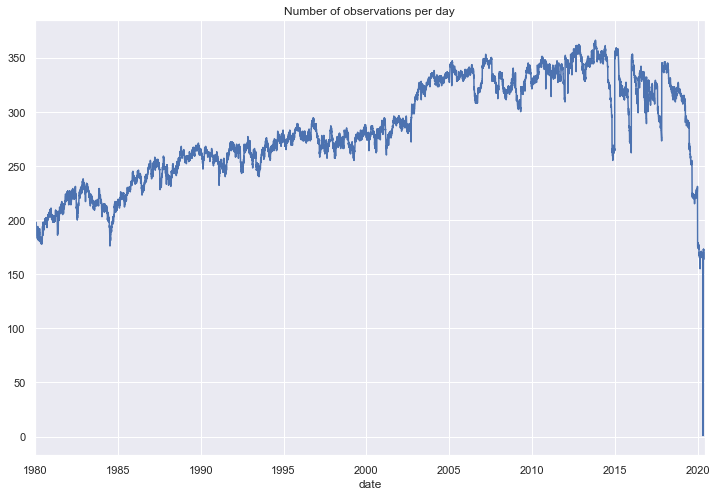

In [8]:
sns.set(rc={'figure.figsize':(12,8)})
data.groupby("date").count()['basin_id'].plot()
plt.title("Number of observations per day")

In [9]:
data.dtypes

date          datetime64[ns]
basin_id               int64
flux                 float64
precip               float64
temp_max             float64
gauge_name            object
lat                  float64
lon                  float64
mean_elev            float64
area_km2             float64
id                     int64
dtype: object

In [10]:
data.groupby("gauge_name").count()

,date,basin_id,flux,precip,temp_max,lat,lon,mean_elev,area_km2,id
gauge_name,,,,,,,,,,
Captacion Lenca,3376,3376,3376,3376,3376,3376,3376,3376,3376,3376
Estero Alhue En Quilamuta,12791,12791,12791,12791,12791,12791,12791,12791,12791,12791
Estero Arrayan En La Montosa,13756,13756,13756,13724,13724,13756,13756,13756,13756,13756
Estero Bellavista En Tom,3761,3761,3761,3729,3729,3761,3761,3761,3761,3761
Estero Camisas En Desembocadura,6247,6247,6247,6247,6247,6247,6247,6247,6247,6247
...,...,...,...,...,...,...,...,...,...,...
Rio Volcan En Queltehues,12837,12837,12837,12805,12805,12837,12837,12837,12837,12837
Rio ÑIreguao En Villa MaÑIguales,12714,12714,12714,12714,12714,12714,12714,12714,12714,12714
Rio ÑUble En La Punilla,13685,13685,13685,13685,13685,13685,13685,13685,13685,13685


### Functions

Plot flux, temperature and precipitations:

a) Write a function that plot a time series of a specific variable (flux, temp, precip) from a station.<br>
b) Now write a function that plots the 3 variables at the same time. As the variables are in different scales, you can normalize before plotting them. 

In [11]:
def plot_one_timeserie(cod_station, variable, min_date, max_date):
    sns.set(rc={'figure.figsize':(12,8)})
    
    df = data[(data["gauge_name"] == cod_station)
             &(data['date'] >= min_date)
             &(data['date'] <= max_date)].copy()

    ax = sns.lineplot(x = 'date',
                      y = variable,
                      data = df)
    title = variable + " for " + cod_station + "\n" + min_date + " to "  + max_date
    plt.ylabel(variable ,size = 15)
    plt.title(title, size = 18)
    plt.show()

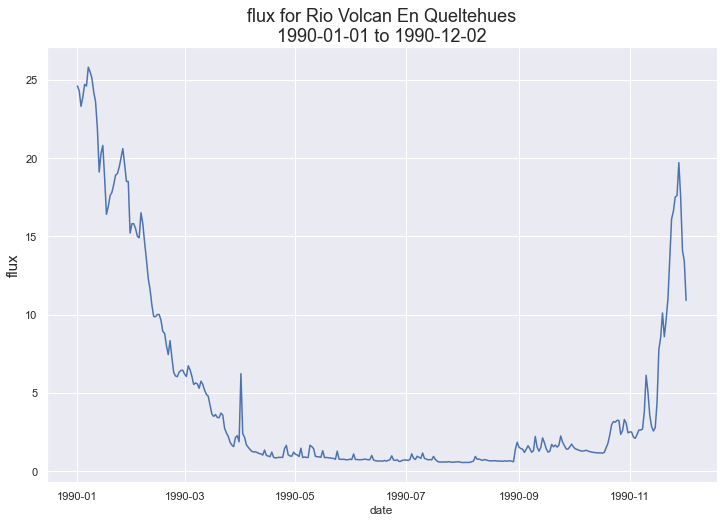

In [12]:
plot_one_timeserie("Rio Volcan En Queltehues", "flux", "1990-01-01", "1990-12-02")

In [13]:
def plot_three_timeseries(cod_station, min_date, max_date):
    sns.set(rc={'figure.figsize':(12,8)})
    df = data[(data["gauge_name"] == cod_station)
             &(data['date'] >= min_date)
             &(data['date'] <= max_date)].copy()
    
    def normalize(x):
        return ((x - x.mean())/x.std())
    
    
    df = df.assign(temp_max_norm = normalize(df['temp_max']),
                   flux_norm = normalize(df['flux']),
                   precip_norm = normalize(df['precip']))
    
    ax = sns.lineplot(x = 'date',
                      y = 'temp_max_norm',
                      data = df,
                      label = 'temp_max_norm')
    
    bx = sns.lineplot(x = 'date',
                      y = 'flux_norm',
                      data = df,
                      label = 'flux_norm')
    
    
    cx = sns.lineplot(x = 'date',
                      y = 'precip_norm',
                      data = df,
                      label = 'precip_norm') 
    title = "Normalized Variables "+ cod_station + "\n" + min_date + " to "  + max_date
    plt.ylabel("")
    plt.title(title, size = 18)
    plt.show()

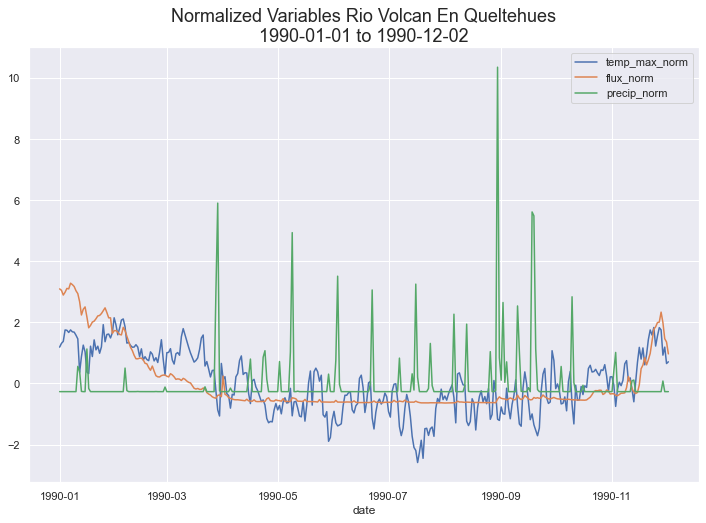

In [14]:
plot_three_timeseries("Rio Volcan En Queltehues", "1990-01-01", "1990-12-02")

### Create three variables called:

- flux_extreme
- temp_extreme
- precip_extreme
<br>
This variables should take the value of 1 when that variable in a specific day was extreme. Being extreme could be considered as being greater than expected. For example, a flux can be considered as extreme (value 1) when is over the 95 percentile of the flux distribution for that specific season, and takes the value 0 otherwise. Taking into account the seasonality of that variables is very important, because  could be considered as extreme in wintertime, but it’d be a normal temperature for summertime.
<br>
Do you consider this a good way of capturing extreme events? Or you would have used a different method? Which one?




In [15]:
# Creating different seasons (I used Meteorological seasons definition instead of Astronomical)
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))
data['season'] = data.date.dt.month.map(month_to_season)

In [16]:
def extreme(df, variable):
    df_quantile = df.groupby(["season", "basin_id"]).quantile([0.95]).reset_index()
    df_quantile = df_quantile[["season", "basin_id", variable]].rename(columns = {variable: variable + "_95"})
    df = pd.merge(df, df_quantile, 
                on = ["season", "basin_id"])
    df[variable + '_extreme'] = (df[variable] >  df[variable + "_95"])*1
    df = df.drop(columns = [variable + "_95", ])
    return df

In [17]:
for variable in ['flux', 'temp_max', 'precip']:
    data = extreme(data, variable)

In [18]:
data.head()

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2,id,season,flux_extreme,temp_max_extreme,precip_extreme
0,1980-01-01,1001001,0.579,0.0,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,1,1,0,0,0
1,1980-01-02,1001001,0.543,0.0,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,2,1,0,0,0
2,1980-01-03,1001001,0.482,0.0,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,3,1,0,0,0
3,1980-01-04,1001001,0.459,0.0,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,4,1,0,0,0
4,1980-01-05,1001001,0.436,0.0,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,5,1,0,0,0


### 5 Plot the variable flux_extreme
Are there any different behaviours among different watersheds?

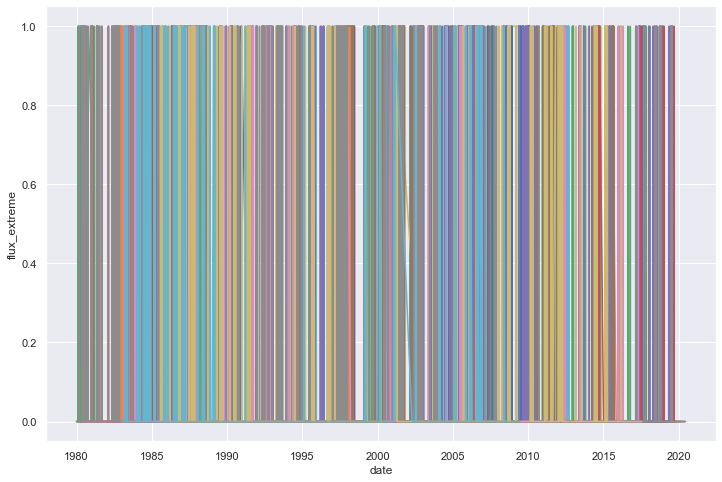

In [19]:
stations = data.gauge_name.unique()
random.shuffle(stations)
for station in stations[:20]:

    min_date_plt = str(data[data.gauge_name == station]['date'].min().date())
    max_date_plt = str(data[data.gauge_name == station]['date'].max().date())
    df = data[(data["gauge_name"] == station)
              &(data['date'] >= min_date_plt)
              &(data['date'] <= max_date_plt)].copy()
    
    ax = sns.lineplot(x = 'date',
                      y = 'flux_extreme',
                      data = df)


### 6 Plot the percentage of extreme events during time

Have they become more frequent?



In [ ]:
for variable in ['flux_extreme', 'temp_max_extreme', 'precip_extreme']:
    # Daily percentage 
    avg = data.groupby("date").mean()[variable]
    
    # Plot
    avg.plot(label = 'Daily average')
    plt.title("Percentage of "+ variable +" - Overall", size = 18)
    plt.legend()
    plt.ylabel(variable)    
    plt.show()


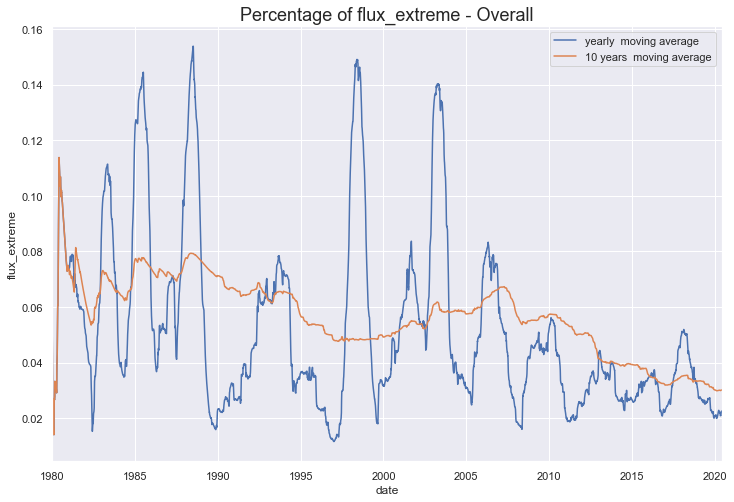

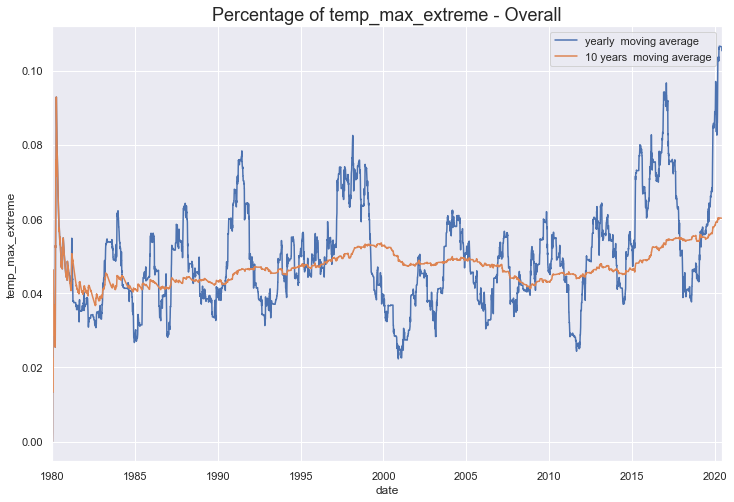

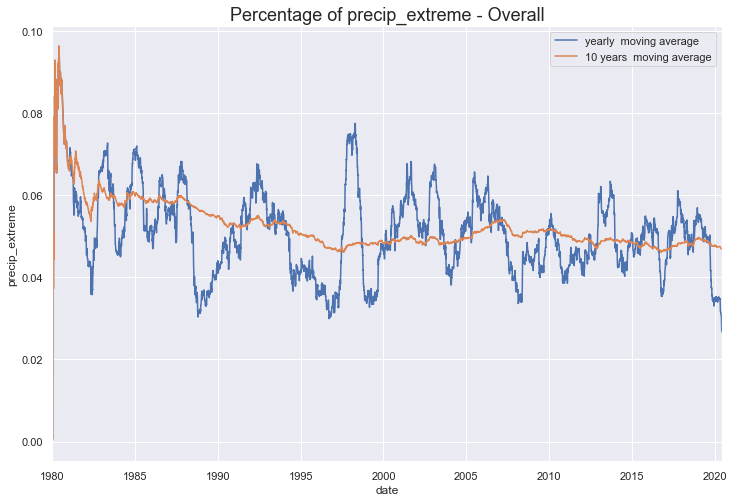

In [20]:
for variable in ['flux_extreme', 'temp_max_extreme', 'precip_extreme']:
    # Daily percentage
    avg = data.groupby("date").mean()[variable]
    
    # Calculating yearly and 10 years moving average
    mv_avg_y = avg.rolling(365,1).mean()
    mv_avg_10y = avg.rolling(10*365,1).mean()

    # Plot
    mv_avg_y.plot(label = 'yearly  moving average')
    mv_avg_10y.plot(label = '10 years  moving average')
    plt.title("Percentage of "+ variable +" - Overall", size = 18)
    plt.legend()
    plt.ylabel(variable)    
    plt.show()


### 7 Extreme flux prediction

Train one or many models (using your preferred algorithms) for estimating the probability of having an extreme flux. Feel free to create new features or use external variables. Some of the discussion we would like to see: Which data can be used and which cannot? Of course, we cannot use future data, but what about data from the same day? Or from the previous day?<br>

Everything depends on how you propose the model use. Make a proposal on how you would use the model in practice (for example, once trained, the model will predict next day probability). Depending on your proposal, set constraints about which variables you can or cannot use.

### Creating new features

In [21]:
def last_ndays_sum(df,variable,n):
    col_name = f"{variable}_last_{n}_days"
    df[col_name] = 0
    for i in range(1,n+1):
        df[col_name] += np.where(df.basin_id.eq(df.basin_id.shift(1)),df.shift(i, fill_value = 0)[variable],0)
    return df

In [22]:
data_model = data.copy()

In [23]:
# Features of precipitation, temp_max and flux for last n days
# Including extreme events for last n days

ndays_list = [1,3,7]
variables = ['flux', 'temp_max', 'precip', 'precip_extreme', 'flux_extreme', 'temp_max_extreme']

for days in ndays_list:
    for variable in variables:
        data_model = last_ndays_sum(data_model,variable,days)
        
# Features of precipitation over area for last n days

for days in ndays_list:
    data_model[f"precip_area_{days}_days"] = data_model[f'precip_last_{days}_days'] / data_model['area_km2']

Passing <class 'int'> to shift is deprecated and will raise in a future version, pass Timestamp instead.


### Features List

In [24]:
features = data_model.columns.drop(['date', 
                                    'id',
                                    'gauge_name', 
                                    'flux',
                                    'precip',
                                    'temp_max',
                                    'lat', 'lon',
                                    'flux_extreme',
                                    'temp_max_extreme',
                                    'precip_extreme'
                                   ])
target = 'flux_extreme'

categorical_features = ['basin_id']
numerical_features = list(set(features) - set(categorical_features))
print("Number of Features:", len(features))


Number of Features: 25


### Data Splitting

In [25]:
df_train, df_test, _, df_holdout = space_time_split_dataset(dataset = data_model, 
                                                            train_start_date = "1980-01-01",
                                                            train_end_date = "2010-01-01",
                                                            holdout_end_date = "2020-01-01",
                                                            split_seed = 123,
                                                            space_holdout_percentage = 0.2,
                                                            time_column = "date",
                                                            space_column = "id",
                                                           )

print(df_train.shape, df_test.shape, df_holdout.shape)

(2371916, 36) (592978, 36) (1189754, 36)


### Training

In [26]:
lgbm_model = lgbm.LGBMClassifier(
    random_seed=42,
)

lgbm_model.fit(X = df_train[features],
               y = df_train[target],
               categorical_feature = categorical_features
               )



Using categorical_feature in Dataset.


LGBMClassifier(random_seed=42)

# 8.Analyze the model results.

a) What is the performance of the model? Which metrics you consider are the best suited for this problem? What are the most important variables? What do you think about the results?<br>
b) If we wanted to identify at least 70% of the extreme flux events, which are the metrics of your model for that threshold? It is a useful model?<br>

### Measure Performance

In [27]:
def score_and_measure_performance(df, model):
    scores = model.predict_proba(df[features])[:,1]
    auc = roc_auc_score(df[target], scores)
    ll = log_loss(df[target], scores)
    return auc, ll

In [28]:
i = 0
split = ["Train", "Test", "Temporal holdout"]
for df in (df_train, df_test, df_holdout):
    auc, ll = score_and_measure_performance(df, lgbm_model)
    print(split[i])
    print("AUC:", auc)
    print("LogLoss:", ll)
    print("")
    i+=1

Train
AUC: 0.9814186635962152
LogLoss: 0.06136138135020113

Test
AUC: 0.9792654726791381
LogLoss: 0.06433990469824026

Temporal holdout
AUC: 0.9731384196851116
LogLoss: 0.04861840525156442



### Feature Importance - SHAP

In [29]:
def get_shap_values(model, df):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df)
    return shap_values

In [30]:
shap_lgbm = get_shap_values(lgbm_model.booster_, df_train[features].sample(frac=0.1, random_state=42))

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [31]:
df_shap_lgbm = pd.DataFrame(shap_lgbm[1], columns=features)

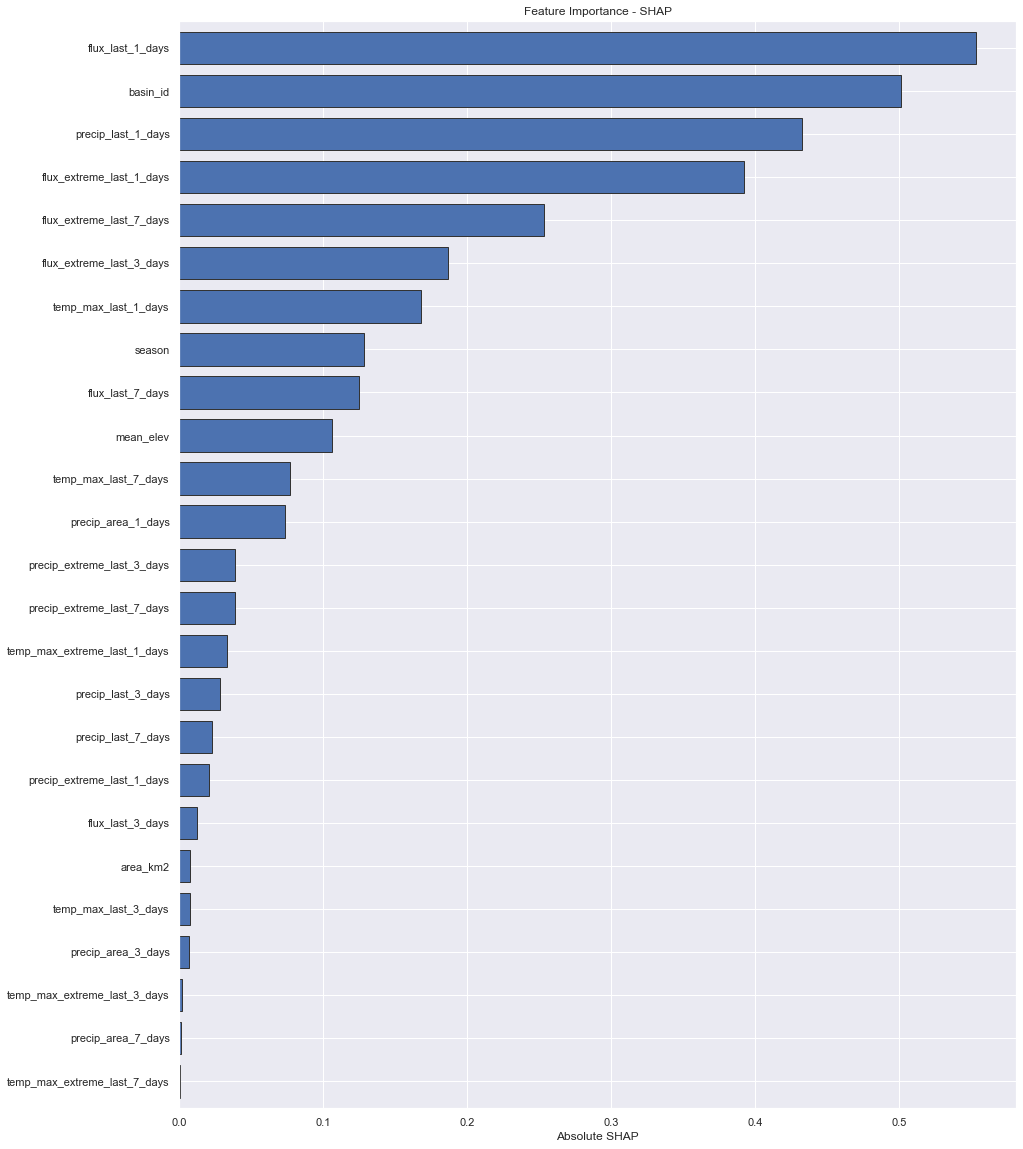

In [32]:
df_shap_lgbm.abs().mean().sort_values(ascending = True).plot.barh(figsize=(15, 1/3 * 60), edgecolor='0.2', width=0.75)
plt.title("Feature Importance - SHAP")
plt.xlabel("Absolute SHAP")
plt.show()

In [33]:
def violin_plot(df, data):
    feature_order_mean = df.abs().mean().sort_values(ascending=False).index
    feat_groups = np.array_split(feature_order_mean, ceil(len(feature_order_mean) / 20))
    shap_feat_vals = data.reset_index()
    for feats in feat_groups:
        shap.summary_plot(df[feats].to_numpy(),
                          shap_feat_vals.loc[df.index][feats],
                          cmap=sns.color_palette('Spectral_r', as_cmap=True))

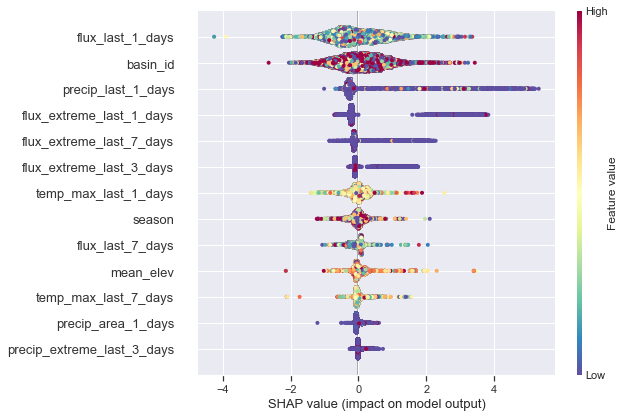

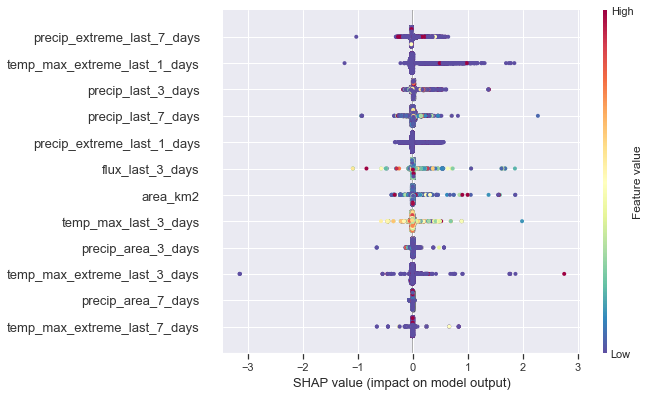

In [34]:
violin_plot(df_shap_lgbm, df_train[features])

### ROC Curve

In [35]:
df_roc = pd.DataFrame()

cols = ['false_positive_rate', 'true_positive_rate', 'threshold']
split = ["train", "test", "holdout"]
i=0
for df in (df_train, df_test, df_holdout):

    df_roc_split = pd.DataFrame()
    scores = lgbm_model.predict_proba(df[features])[:,1]
    
    fpr, tpr , thresolds = roc_curve(df[target], scores)
    df_roc_model = pd.DataFrame([fpr, tpr, thresolds]).transpose().rename(columns = {0:"false_positive_rate", 
                                                                                     1:"true_positive_rate",
                                                                                     2:"threshold"})

    df_roc_split = pd.concat([df_roc_split, df_roc_model], axis = 0)
    df_roc_split['split'] = split[i]    
    df_roc = pd.concat([df_roc, df_roc_split], axis = 0)
    i+=1
    

In [47]:
def roc_curve_plot(df, split_list):
#     df_ = df[df.split == split]
    plt.figure(figsize=(10, 7), dpi=100)
#     plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC ROC")
    for split in split_list:
        df_plt = df[df.split == split]
        plt.plot(df_plt.false_positive_rate, df_plt.true_positive_rate)
    plt.
    plt.legend(split_list)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

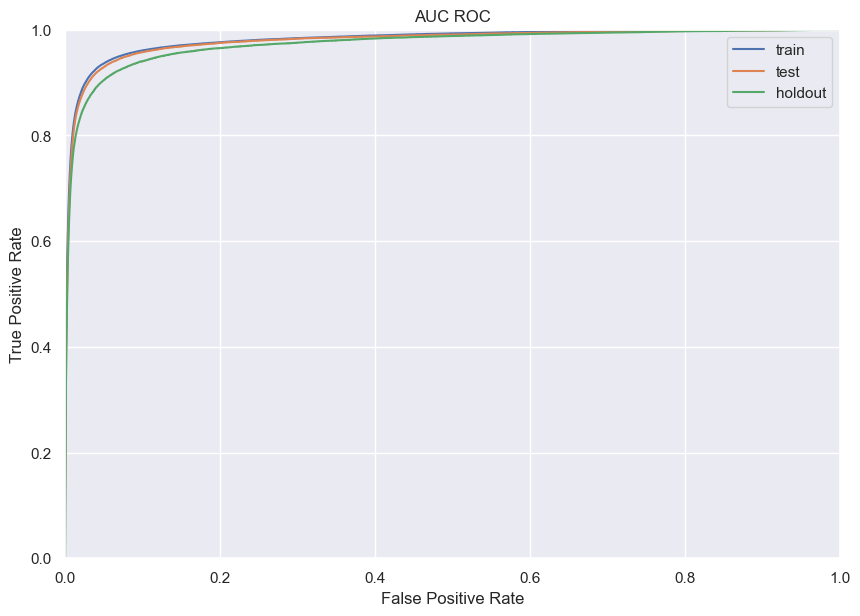

In [48]:
roc_curve_plot(df_roc,split)